# **TDP Week 3** - Electric Probes

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sdas.tests.LoadSdasData import LoadSdasData
from sdas.tests.StartSdas import StartSdas

plt.style.use('bmh')

## **$1^{st}$ Part:**

Effect of the cut-off voltage on the estimated plasma parameters (particularly on the
electron temperature and fit quality)
for one I-V characteristic showing a deviation from
the exponential behaviour (data in table 1) [Note: I will consider 3 to 4 I-V characteristic curves.]

<center>

|shot ID|collected current ID|applied voltage|
|-----|-----------|-----------|
|35605|CHANNEL_030|CHANNEL_026|
|36892|CHANNEL_028|CHANNEL_029|
|36892|CHANNEL_026|CHANNEL_029|

**Table 1:** Data for the cut-off voltage analysis.

</center>

**Note:** The units of the signals are: Time ($\mu s$), Collected current (mA) and Applied voltage (V). 

In [2]:
# Load and select data
shot = 35605
client = StartSdas()
V_data, time = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_026', shot)
I_data, _ = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_030', shot)

In [3]:
def color_title(labels, colors, textprops ={'size':'large'}, ax = None, y = 1.033,
               precision = 10**-2):
     
    "Creates a centered title with multiple colors."
        
    if ax == None:
        ax = plt.gca()
        
    plt.gcf().canvas.draw()
    transform = ax.transAxes # use axes coords
    
    # initial params
    xT = 0 # where the text ends in x-axis coords
    shift = 0 # where the text starts
    
    # for text objects
    text = dict()

    while (np.abs(shift - (1-xT)) > precision) and (shift <= xT) :         
        x_pos = shift 
        
        for label, col in zip(labels, colors):

            try:
                text[label].remove()
            except KeyError:
                pass
            
            text[label] = ax.text(x_pos, y, label, 
                        transform = transform, 
                        ha = 'left',
                        color = col,
                        **textprops)
            
            x_pos = text[label].get_window_extent()\
                   .transformed(transform.inverted()).x1
            
        xT = x_pos # where all text ends
        
        shift += precision/2 # increase for next iteration
      
        if x_pos > 1: # guardrail 
            break

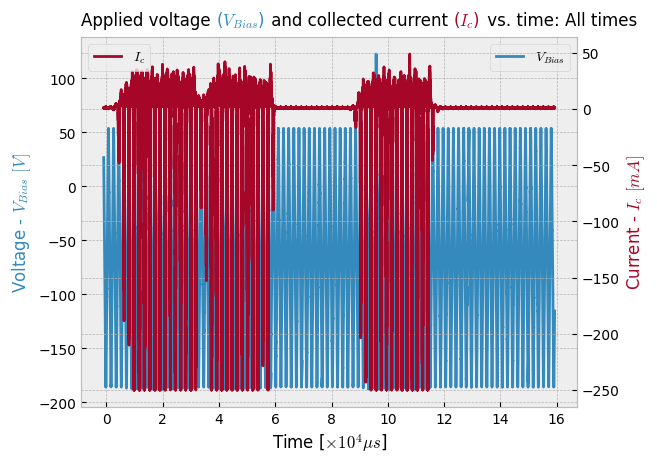

<Figure size 640x480 with 0 Axes>

In [4]:
# "Interactive" plots: Change 'inline' to 'widget'
%matplotlib inline

# Getting to know our data:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time*1e-4, V_data, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time*1e-4, I_data, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\times 10^{4}\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time: All times']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.savefig('1_V&I(t).svg', format = 'svg')
plt.show()
plt.clf()
# Here, the 3 cycles are visible.

In [5]:
# Selecting a time interval:
bool_indices = (time > 50500) & (time < 53900) # Considering 2 I-V curves, in the 2nd cycle.
V_data_d = V_data[bool_indices]
I_data_d = I_data[bool_indices]
time_d = time[bool_indices]
print(f'Time interval = [{time_d[0]}, {time_d[-1]}] us.')

Time interval = [50500.5, 53899.5] us.


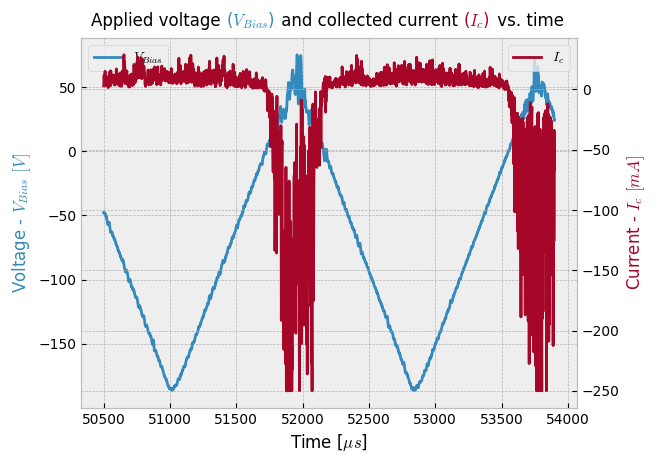

<Figure size 640x480 with 0 Axes>

In [6]:
# Plotting the selected time interval:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time_d, V_data_d, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time_d, I_data_d, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend()
ax2.legend()
plt.savefig('1_V&I(t)_2_Curves.svg', format = 'svg')
plt.show()
plt.clf()

In [7]:
from uncertainties import ufloat
from scipy.stats import chisquare

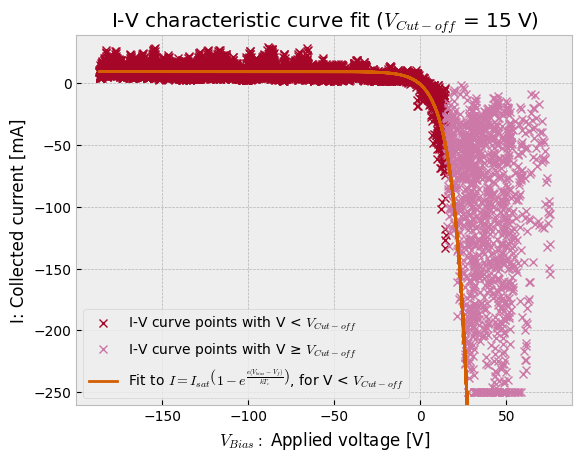

I_Sat = 9.18+/-0.09 [mA]
V_f = -0.98+/-0.26 [V]
T_e = 8.39+/-0.17 [eV]
C_s = (4.01+/-0.04)e+04 [m/s]
n_e = (4.77+/-0.07)e+20 [m**(-3)]
V_p = 24.2+/-0.6 [V]
R^2 = 0.6730491816997528
Sum of squared residues normalized to the number of points = 38.24


<Figure size 640x480 with 0 Axes>

In [8]:
from scipy.odr import *

# Defining constants:
e = 1.602177e-19     # Electron charge.    [This ('e' and 'k') leads to overflow (if introduced directly in fitting formula)!
k = 1.380649e-23     # Boltzmann constant.  Keep this in mind!]
m_i = 1.67262192e-27 # Ion mass (In our case of a hydrogen plasma, this is equal to the proton mass!)
A = 6e-6             # Probe area

# Fit data and plot
cut_off = 15
indices = (V_data_d < cut_off)
V_data_d_Cut = V_data_d[indices]
I_data_d_Cut = I_data_d[indices]

V_data_d_Not_Considered = V_data_d[~indices]
I_data_d_Not_Considered = I_data_d[~indices]

def func(V_Bias, I_Sat, V_f, T_ef): # T_ef = T_e*(k/e)
    return I_Sat * (1 - np.exp((V_Bias - V_f)/(T_ef)))
parameters, covariance = curve_fit(func, V_data_d_Cut, I_data_d_Cut)

# For computing R-Squared:
y = I_data_d_Cut
y_fit = func(V_data_d_Cut, *parameters)
# Residual sum of squares
ss_res = np.sum((y - y_fit) ** 2)
# Total sum of squares
ss_tot = np.sum((y - np.mean(y)) ** 2)
# # R-Squared
R2 = 1 - (ss_res / ss_tot)

# Plotting fit results:
plt.plot(V_data_d_Cut, I_data_d_Cut, 'x',
label=r'I-V curve points with V < $V_{Cut-off}$',
color = 'C1')
plt.plot(V_data_d_Not_Considered, I_data_d_Not_Considered,'x',
label=r'I-V curve points with V ≥ $V_{Cut-off}$',
color = 'C5')
plt.plot(V_data_d, func(V_data_d, *parameters),
label=r'Fit to $I=I_{s a t}\left(1-e^{\frac{e\left(V_{b i a s}-V_f\right)}{k T_e}}\right)$, for V < $V_{Cut-off}$',
color = 'C4')

plt.ylim([min(I_data_d) - 10, max(I_data_d) + 10])
plt.title(r'I-V characteristic curve fit ($V_{Cut-off}$' + f' = {cut_off} V)')
plt.xlabel(r'$V_{Bias}:$ Applied voltage [V]')
plt.ylabel(r'I: Collected current [mA]')
plt.grid(True)
plt.legend(loc = 'best')
plt.savefig('1_I(V)_Fit(V_Cutt-off = 15).svg', format = 'svg')
plt.show()
plt.clf()

# Retrieving parameters and their standard deviations:
# 'parameters' This is defined already!
perr = np.sqrt(np.diag(covariance))

# I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
T_e_ufloat = ufloat(parameters[2], perr[2])
T_e_ufloat*=(e/k)

I_Sat_ufloat = ufloat(parameters[0], perr[0])
V_f_ufloat = ufloat(parameters[1], perr[1])

C_s_ufloat = ((2*k*T_e_ufloat)/(m_i))**(1/2)
n_e_ufloat = I_Sat_ufloat/(0.5*e*A*C_s_ufloat)
V_p_ufloat = V_f_ufloat + 3*k*T_e_ufloat/e


# Printing results
print(f'I_Sat = {I_Sat_ufloat} [mA]')
print(f'V_f = {V_f_ufloat} [V]')
print(f'T_e = {T_e_ufloat*k/e} [eV]')

print(f'C_s = {C_s_ufloat} [m/s]')
print(f'n_e = {n_e_ufloat} [m**(-3)]')
print(f'V_p = {V_p_ufloat} [V]')

print(f'R^2 = {R2}')
print(f'Sum of squared residues normalized to the number of points = {ss_res/len(y):.2f}')


In [9]:
def Plasma_Params(V_cutoff):

    """
    Input: Cut-off voltage.
    Output: 1. 'all_parameters' vector:
        - all_parameters[0] -> I_Sat
        - all_parameters[1] -> V_f
        - all_parameters[2] -> T_e
        - all_parameters[3] -> C_s
        - all_parameters[4] -> n_e
        - all_parameters[5] -> V_p
            2. 'all_perr' vector:
        - all_perr[0] -> std_dev(I_Sat)
        - all_perr[1] -> std_dev(V_f)
        - all_perr[2] -> std_dev(T_e)
        - all_perr[3] -> std_dev(C_s)
        - all_perr[4] -> std_dev(n_e)
        - all_perr[5] -> std_dev(V_p)
    """

    indices = (V_data_d < V_cutoff)
    V_data_d_Cut = V_data_d[indices]
    I_data_d_Cut = I_data_d[indices]

    # Defining fitting function and fitting:
    def func(V_Bias, I_Sat, V_f, T_ef): # T_ef = T_e*(k/e)
        return I_Sat * (1 - np.exp((V_Bias - V_f)/(T_ef)))
    parameters, covariance = curve_fit(func, V_data_d_Cut, I_data_d_Cut)

    # For computing R-Squared:
    y = I_data_d_Cut
    y_fit = func(V_data_d_Cut, *parameters)
    # Residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    # Total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # # R-Squared
    R2 = 1 - (ss_res / ss_tot)

    # Retrieving parameters and their standard deviations:
    # 'parameters' This is defined already!
    perr = np.sqrt(np.diag(covariance))
    
    # I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
    T_e_ufloat = ufloat(parameters[2], perr[2])
    T_e_ufloat*=(e/k)

    I_Sat_ufloat = ufloat(parameters[0], perr[0])
    V_f_ufloat = ufloat(parameters[1], perr[1])

    C_s_ufloat = ((2*k*T_e_ufloat)/(m_i))**(1/2)
    n_e_ufloat = I_Sat_ufloat/(0.5*e*A*C_s_ufloat)
    V_p_ufloat = V_f_ufloat + 3*k*T_e_ufloat/e
    
    all_parameters = np.array([parameters[0], parameters[1], T_e_ufloat.n, C_s_ufloat.n, n_e_ufloat.n, V_p_ufloat.n])
    all_perrs = np.array([perr[0], perr[1], T_e_ufloat.s, C_s_ufloat.s, n_e_ufloat.s, V_p_ufloat.s])

    return(all_parameters, all_perrs/all_parameters*100, ss_res/len(y)) # Percentages!

In [10]:
# Defining cut-off voltages sweep:
V_Cutoff_Sweep = np.linspace(0, 70, 1000) # Maybe try to change intial parameters guess (beta0)? # 1000 points.

y = []
yerr = []
SSR_N_vals = [] # Sum of Squared Residues Normalized to the number of points considered in the fit.

# Computing plasma parameters (and their uncertainties) for each value of the cut-off voltage (in the sweep):
for x in V_Cutoff_Sweep:
    y.append(Plasma_Params(x)[0])
    yerr.append(Plasma_Params(x)[1])
    SSR_N_vals.append(Plasma_Params(x)[2])

In [11]:
# Values obtained for multiple cut-off voltages:
# Values:
I_Sat_list = [arr[0] for arr in y]
V_f_list   = [arr[1] for arr in y]
T_e_list   = [arr[2] for arr in y]
C_s_list   = [arr[3] for arr in y]
n_e_list   = [arr[4] for arr in y]
V_p_list   = [arr[5] for arr in y]

# Uncertainties:
I_Sat_err_list = [arr[0] for arr in yerr]
V_f_err_list   = [arr[1] for arr in yerr]
T_e_err_list   = [arr[2] for arr in yerr]
C_s_err_list   = [arr[3] for arr in yerr]
n_e_err_list   = [arr[4] for arr in yerr]
V_p_err_list   = [arr[5] for arr in yerr]

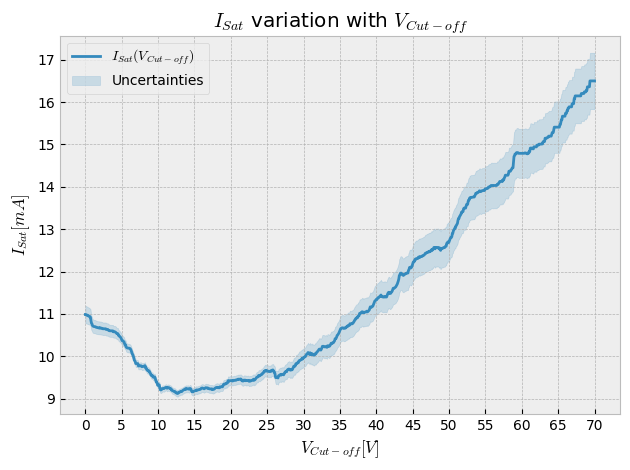

In [12]:
# Ion saturation current graph:
plt.plot(V_Cutoff_Sweep, I_Sat_list, 'C0-', label=r'$I_{Sat}(V_{Cut-off})$')
plt.fill_between(V_Cutoff_Sweep, np.array(I_Sat_list) - np.array(I_Sat_err_list)/100*np.array(I_Sat_list), np.array(I_Sat_list) + np.array(I_Sat_err_list)/100*np.array(I_Sat_list), color='C0', alpha=0.2, label = 'Uncertainties')
plt.xticks(np.arange(min(V_Cutoff_Sweep), max(V_Cutoff_Sweep)+1, 5.0))
plt.xlabel(r'$V_{Cut-off} [V]$')
plt.ylabel(r'$I_{Sat} [mA]$')
plt.title(r'$I_{Sat}$ variation with $V_{Cut-off}$')
plt.legend()
plt.tight_layout()
plt.savefig('1_I_Sat.svg', format = 'svg')
plt.show()

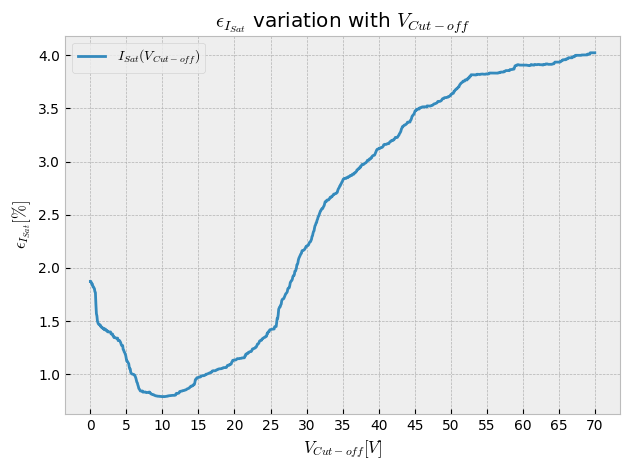

In [44]:
# Ion saturation current uncertainty graph:
plt.plot(V_Cutoff_Sweep, I_Sat_err_list, 'C0-', label=r'$I_{Sat}(V_{Cut-off})$')
plt.xticks(np.arange(min(V_Cutoff_Sweep), max(V_Cutoff_Sweep)+1, 5.0))
plt.xlabel(r'$V_{Cut-off} [V]$')
plt.ylabel(r'$\epsilon_{I_{Sat}} [\%]$')
plt.title(r'$\epsilon_{I_{Sat}}$ variation with $V_{Cut-off}$')
plt.title(r'$\epsilon_{I_{Sat}}$ variation with $V_{Cut-off}$')
plt.legend()
plt.tight_layout()
plt.savefig('1_I_Sat_Eps.svg', format = 'svg')
plt.show()

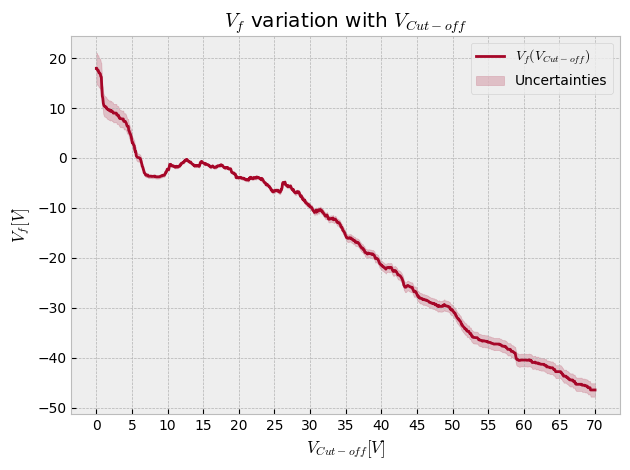

In [14]:
# Floating potential graph:
plt.plot(V_Cutoff_Sweep, V_f_list, 'C1-',   label=r'$V_{f}(V_{Cut-off})$')
plt.fill_between(V_Cutoff_Sweep, np.array(V_f_list) - np.array(V_f_err_list)/100*np.array(V_f_list), np.array(V_f_list) + np.array(V_f_err_list)/100*np.array(V_f_list), color='C1', alpha=0.2, label = 'Uncertainties')
plt.xticks(np.arange(min(V_Cutoff_Sweep), max(V_Cutoff_Sweep)+1, 5.0))
plt.xlabel(r'$V_{Cut-off} [V]$')
plt.ylabel(r'$V_{f} [V]$')
plt.title(r'$V_{f}$ variation with $V_{Cut-off}$')
plt.legend()
plt.tight_layout()
plt.savefig('1_V_f.svg', format = 'svg')
plt.show()

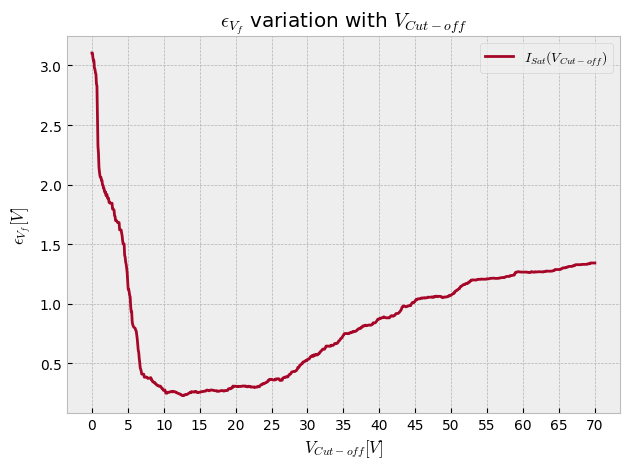

In [43]:
# Floating potential uncertainty graph:
plt.plot(V_Cutoff_Sweep, np.array(V_f_err_list)/100*np.array(V_f_list), 'C1-', label=r'$I_{Sat}(V_{Cut-off})$')
plt.xticks(np.arange(min(V_Cutoff_Sweep), max(V_Cutoff_Sweep)+1, 5.0))
plt.xlabel(r'$V_{Cut-off} [V]$')
plt.ylabel(r'$\epsilon_{V_{f}} [V]$')
plt.title(r'$\epsilon_{V_{f}}$ variation with $V_{Cut-off}$')
plt.title(r'$\epsilon_{V_{f}}$ variation with $V_{Cut-off}$')
plt.legend()
plt.tight_layout()
plt.savefig('1_V_f_Eps.svg', format = 'svg')
plt.show()

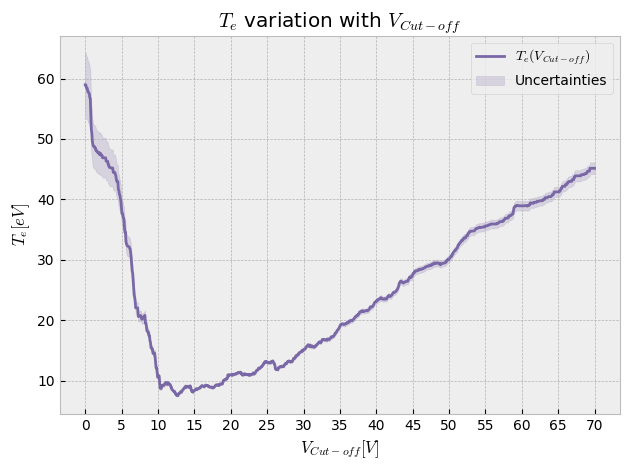

In [16]:
# Electron temperature graph:
plt.plot(V_Cutoff_Sweep, np.array(T_e_list)/11606, 'C2-',   label=r'$T_{e}(V_{Cut-off})$')
plt.fill_between(V_Cutoff_Sweep, np.array(T_e_list)*k/e - np.array(T_e_err_list)*k/e/100*np.array(T_e_list), np.array(T_e_list)*k/e + np.array(T_e_err_list)*k/e/100*np.array(T_e_list), color='C2', alpha=0.2, label = 'Uncertainties')
plt.xticks(np.arange(min(V_Cutoff_Sweep), max(V_Cutoff_Sweep)+1, 5.0))
plt.xlabel(r'$V_{Cut-off} [V]$')
plt.ylabel(r'$T_{e} [eV]$')
plt.title(r'$T_{e}$ variation with $V_{Cut-off}$')
plt.legend()
plt.tight_layout()
plt.savefig('1_T_e.svg', format = 'svg')
plt.show()

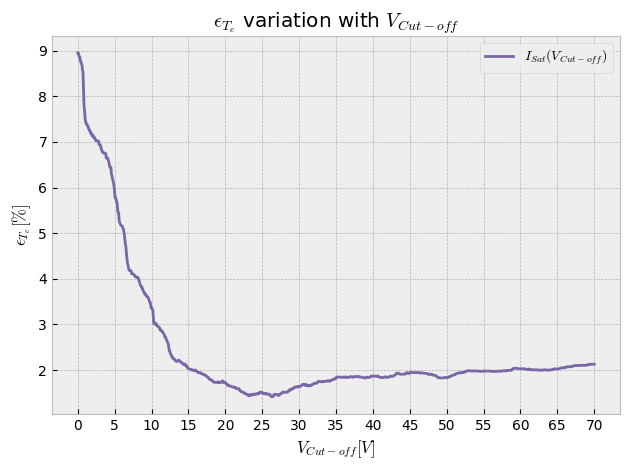

In [37]:
# Electron temperature uncertainty graph:
plt.plot(V_Cutoff_Sweep, T_e_err_list, 'C2-', label=r'$I_{Sat}(V_{Cut-off})$')
plt.xticks(np.arange(min(V_Cutoff_Sweep), max(V_Cutoff_Sweep)+1, 5.0))
plt.xlabel(r'$V_{Cut-off} [V]$')
plt.ylabel(r'$\epsilon_{T_{e}} [\%]$')
plt.title(r'$\epsilon_{T_{e}}$ variation with $V_{Cut-off}$')
plt.title(r'$\epsilon_{T_{e}}$ variation with $V_{Cut-off}$')
plt.legend()
plt.tight_layout()
plt.savefig('1_T_e_Eps.svg', format = 'svg')
plt.show()

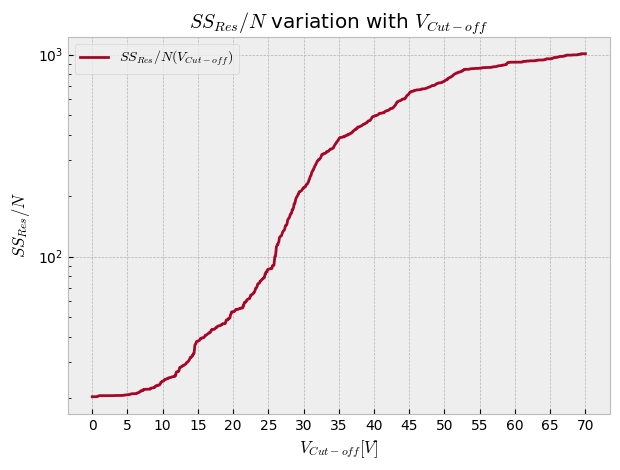

20.244800636241866


In [36]:
# SSR_{N} graph:
plt.plot(V_Cutoff_Sweep, SSR_N_vals, 'C1-',   label=r'$SS_{Res}/N(V_{Cut-off})$') # Changed this to abs()!
plt.xlabel(r'$V_{Cut-off} [V]$')
plt.xticks(np.arange(min(V_Cutoff_Sweep), max(V_Cutoff_Sweep)+1, 5.0))
plt.ylabel(r'$SS_{Res}/N$')
plt.title(r'$SS_{Res}/N$ variation with $V_{Cut-off}$')
plt.legend()
plt.tight_layout()
plt.savefig('1_SSR_N.svg', format = 'svg')
plt.yscale('log')
plt.show()
print(SSR_N_vals[0])

In [19]:
from scipy.signal import argrelextrema # Might be useful for local maximum/minimum calculations!

## **$2^{nd}$ Part:**

Temporal evolution of the plasma parameters along one plasma cycle, ~25 ms (data in
**Table 2**, although data in table 1 may also be used). 

<center>

|shot ID|collected current ID|applied voltage|
|-----|-----------|-----------|
|35604|CHANNEL_030|CHANNEL_026|
|35605|CHANNEL_029|CHANNEL_026|
|36891|CHANNEL_028|CHANNEL_029|
|36891|CHANNEL_026|CHANNEL_029|

**Table 2:** Data for the temporal evolution analysis.

</center>

In [20]:
# Load and select data
shot = 35604
client = StartSdas()
V_data, time = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_026', shot)
I_data, _ = LoadSdasData(client, 'PCIE_ATCA_ADC_16.BOARD_1.CHANNEL_030', shot)

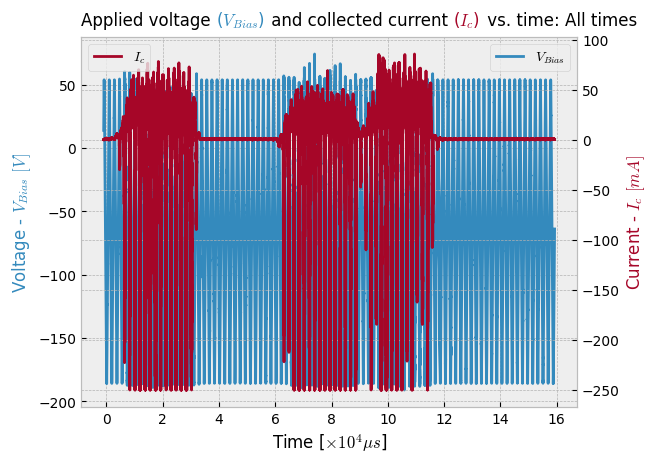

<Figure size 640x480 with 0 Axes>

In [21]:
# "Interactive" plots: Change 'inline' to 'widget'
%matplotlib inline

# Getting to know our data:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time*1e-4, V_data, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time*1e-4, I_data, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\times 10^{4}\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time: All times']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper right')
ax2.legend(loc='upper left')
plt.show()
plt.clf()
# Here, the 3 cycles are visible.

In [22]:
# Selecting a time interval:
bool_indices = (time > 3500) & (time < 33500.5) # Considering only the 1st cycle (~30 ms)
V_data_d = V_data[bool_indices]
I_data_d = I_data[bool_indices]
time_d = time[bool_indices]
print(f't[0] = {time_d[0]}, t[-1] = {time_d[-1]}, Delta_t = {time_d[-1]-time_d[0]}')

t[0] = 3500.5, t[-1] = 33500.0, Delta_t = 29999.5


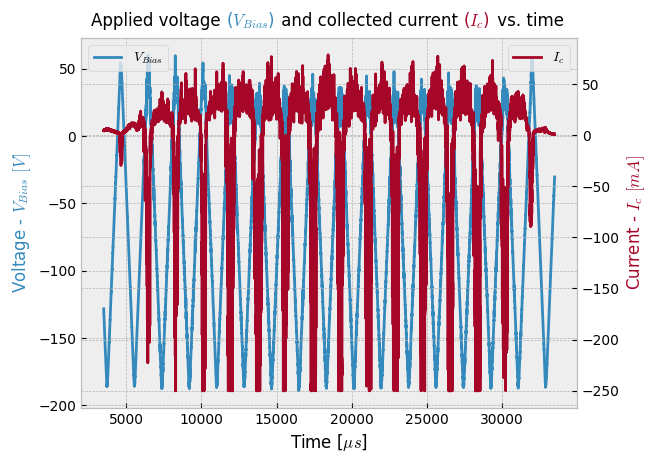

<Figure size 640x480 with 0 Axes>

In [23]:
# Plotting the selected time interval:
fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(time_d, V_data_d, 'C0-', label=r'$V_{Bias}$')
ax2.plot(time_d, I_data_d, 'C1-', label=r'$I_c$')

ax1.set_xlabel(r'Time [$\mu s$]')
ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
colors = ['black', 'C0', 'black', 'C1', 'black']
color_title(label_list, colors)

plt.grid(True)
ax1.legend(loc='upper left')
ax2.legend()
plt.savefig('2_1st_Cycle.svg', format = 'svg')
plt.show()
plt.clf()

In [24]:
# Splitting np.array in 16 chunks, since we seem to have roughly 16 I-V characteristic curves.
print(f' Len(V_data_d) = {len(V_data_d)}') # Debugging: {split_j} must be a divisor of {len(V_data_d)} for 'split' to work!
split_j = 16
V_d = np.split(V_data_d, split_j)
I_d = np.split(I_data_d, split_j)
t_d = np.split(time_d, split_j)

 Len(V_data_d) = 60000


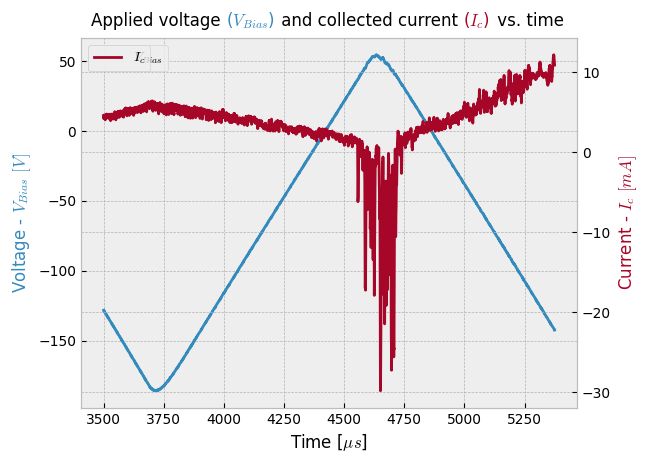

<Figure size 640x480 with 0 Axes>

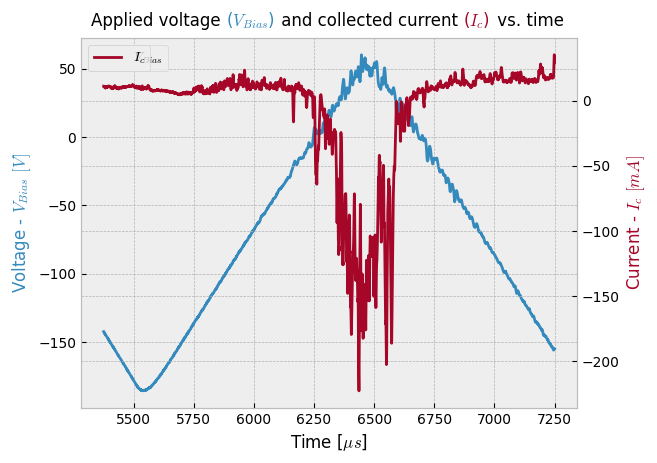

<Figure size 640x480 with 0 Axes>

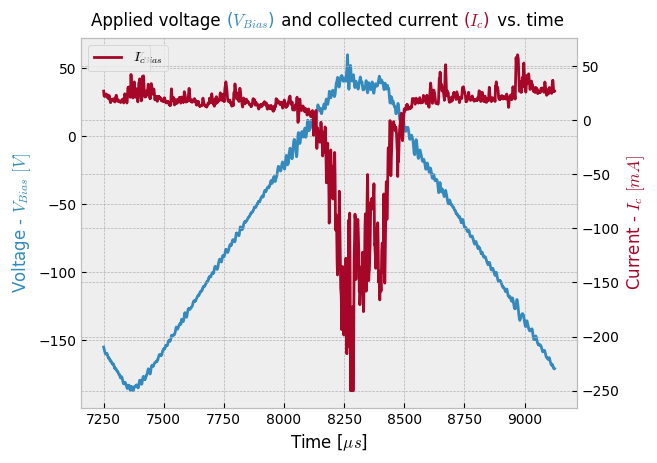

<Figure size 640x480 with 0 Axes>

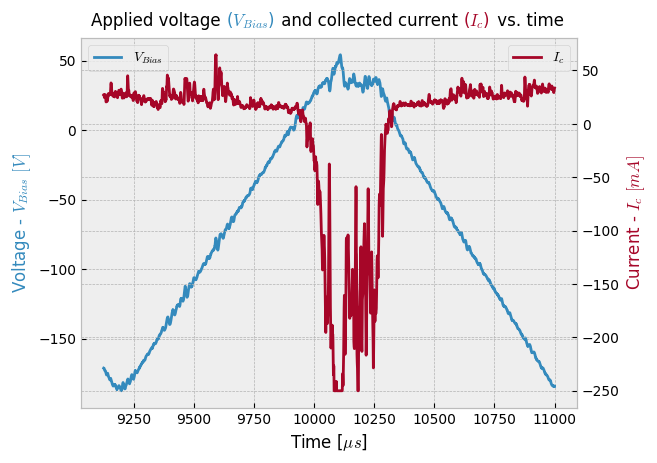

<Figure size 640x480 with 0 Axes>

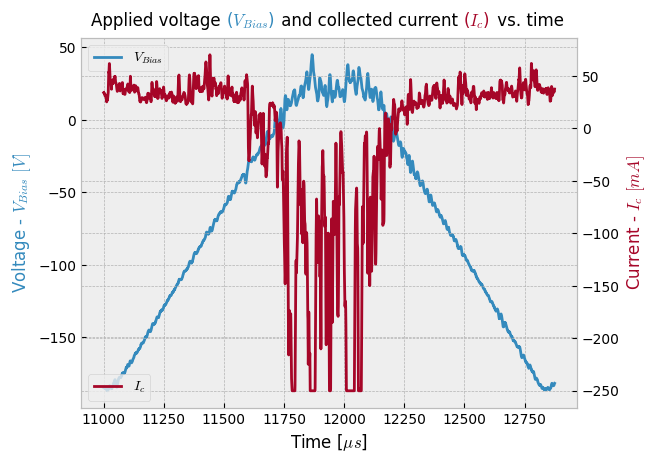

<Figure size 640x480 with 0 Axes>

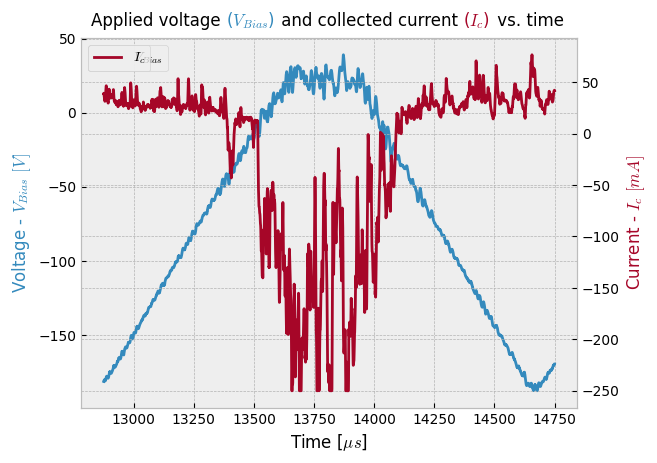

<Figure size 640x480 with 0 Axes>

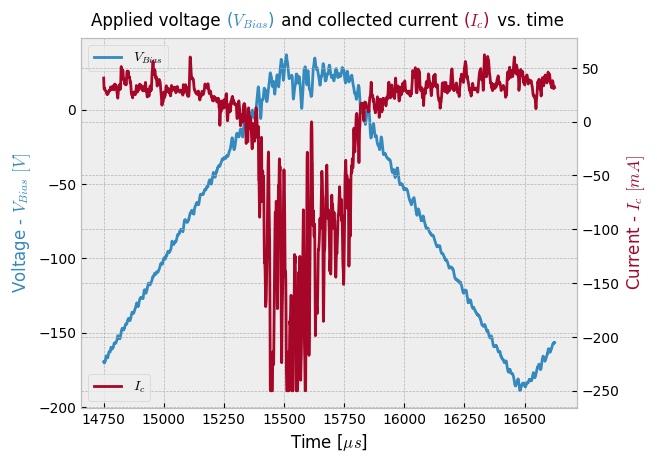

<Figure size 640x480 with 0 Axes>

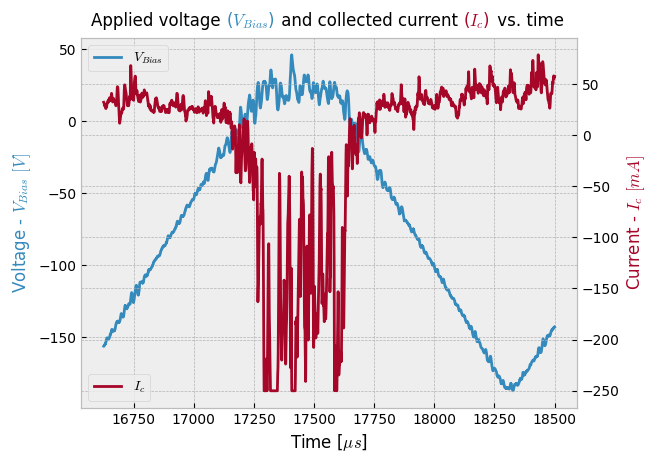

<Figure size 640x480 with 0 Axes>

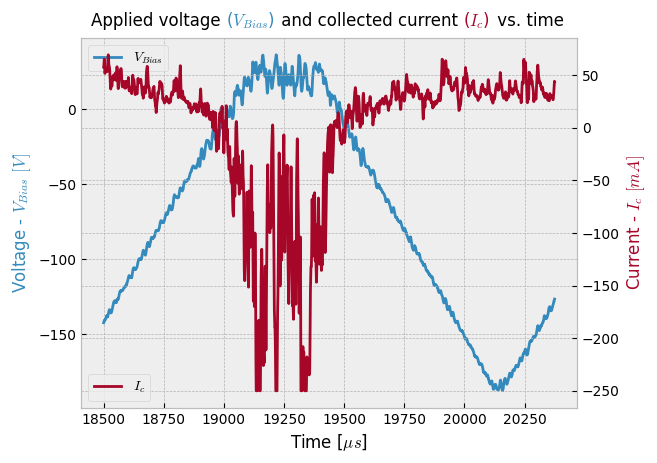

<Figure size 640x480 with 0 Axes>

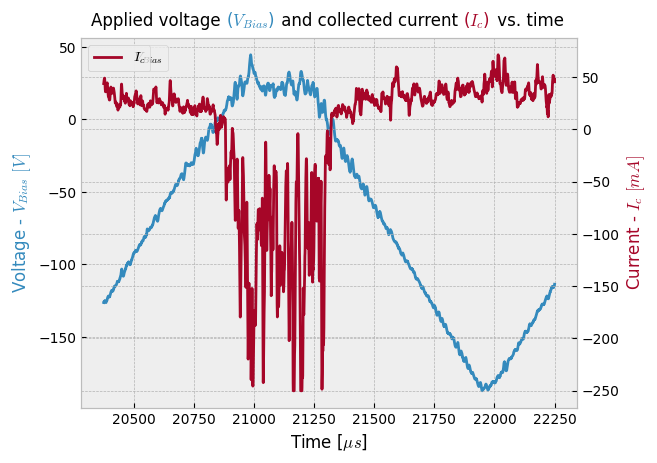

<Figure size 640x480 with 0 Axes>

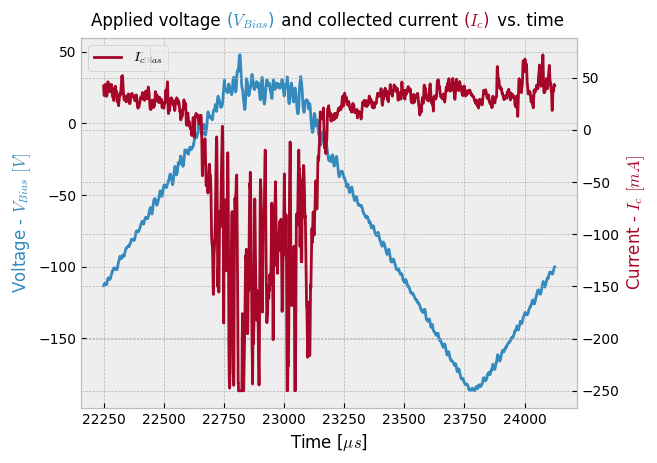

<Figure size 640x480 with 0 Axes>

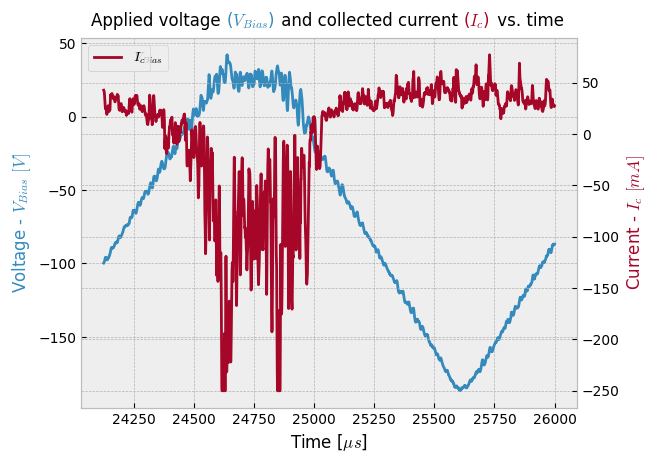

<Figure size 640x480 with 0 Axes>

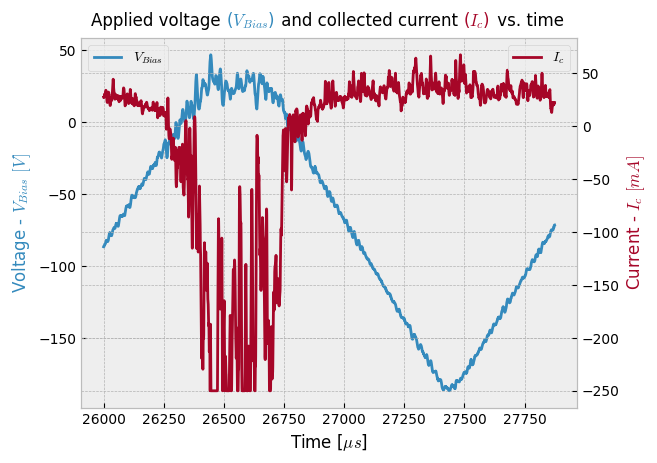

<Figure size 640x480 with 0 Axes>

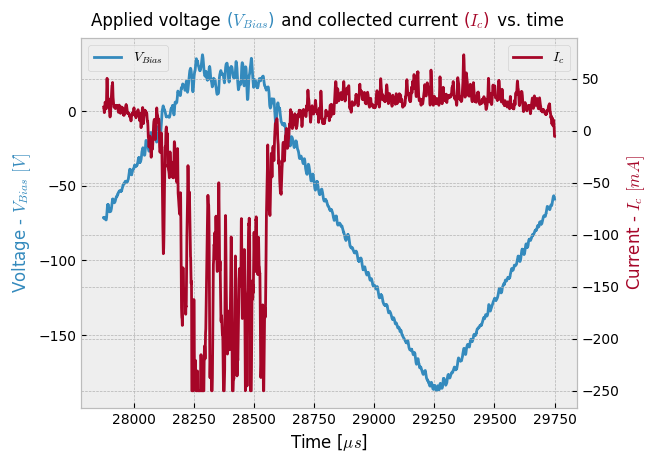

<Figure size 640x480 with 0 Axes>

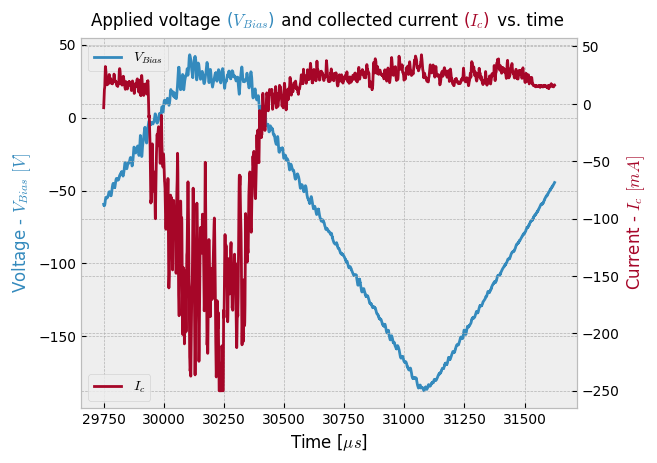

<Figure size 640x480 with 0 Axes>

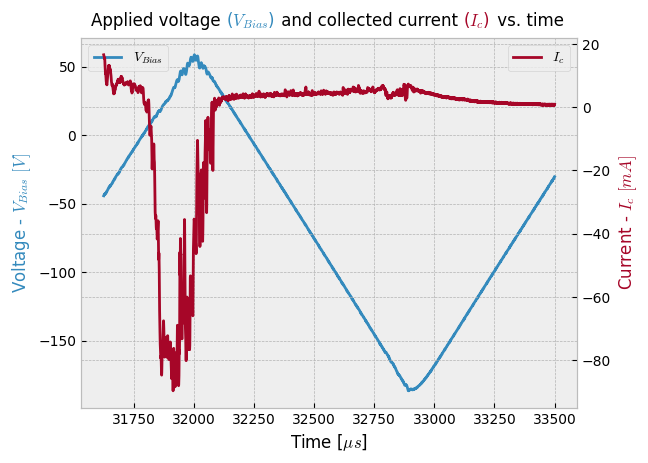

<Figure size 640x480 with 0 Axes>

In [25]:
# Plotting the selected time intervals:
for i in range(0, split_j):
    fig, ax1 = plt.subplots()

    ax2 = ax1.twinx()
    ax1.plot(t_d[i], V_d[i], 'C0-', label=r'$V_{Bias}$')
    ax2.plot(t_d[i], I_d[i], 'C1-', label=r'$I_c$')

    ax1.set_xlabel(r'Time [$\mu s$]')
    ax1.set_ylabel(r'Voltage - $V_{Bias}$ $[V]$', color='C0')
    ax2.set_ylabel(r'Current - $I_c$ $[mA]$', color='C1')

    label_list = ['Applied voltage ', r'($V_{Bias}$) ', ' and collected current ', r'($I_c$) ', ' vs. time']
    colors = ['black', 'C0', 'black', 'C1', 'black']
    color_title(label_list, colors)

    plt.grid(True)
    ax1.legend(loc='upper left')
    ax2.legend()
    plt.show()
    plt.clf()

In [26]:
# Data arrays:
T_e_Time = []
T_e_Time_Epsilon = []
n_e_Time = []
n_e_Time_Epsilon = []
V_f_Time = []
V_f_Time_Epsilon = []
V_p_Time = []
C_s_Time = []
SSR_N_Time = []

for j in range(0, split_j):
    # Note that cut-off voltage was not considered for this analysis!
    # It should, but this would just make things more complicated. Results are fine this way...

    # Defining fitting function and fitting:
    def func(V_Bias, I_Sat, V_f, T_ef): # T_ef = T_e*(k/e)
        return I_Sat * (1 - np.exp((V_Bias - V_f)/(T_ef)))
    parameters, covariance = curve_fit(func, V_d[j], I_d[j], maxfev=5000)

    # For computing R-Squared:
    y = I_d[j]
    y_fit = func(V_d[j], *parameters)
    # Residual sum of squares
    ss_res = np.sum((y - y_fit) ** 2)
    # Total sum of squares
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    # # R-Squared
    R2 = 1 - (ss_res / ss_tot)

    # Retrieving parameters and their standard deviations:
    # 'parameters' This is defined already!
    perr = np.sqrt(np.diag(covariance))

    # Uncomment to see plots of the fits!
    # plt.plot(V_d[j], I_d[j], 'x',
    # label=r'I-V curve points with V < $V_{Cut-off}$',
    # color = 'C1')
    # plt.plot(V_d[j], func(V_d[j], *parameters),
    # label=r'Fit to $I=I_{s a t}\left(1-e^{\frac{e\left(V_{b i a s}-V_f\right)}{k T_e}}\right)$, for V < $V_{Cut-off}$',
    # color = 'C4')

    # plt.ylim([min(I_d[j]) - 1, max(I_d[j]) + 1])

    # plt.title(r'I-V characteristic curve fit ($V_{Cut-off}$' + f' = {cut_off} V)')
    # plt.xlabel(r'$V_{Bias}:$ Applied voltage [V]')
    # plt.ylabel(r'I: Collected current [mA]')
    # plt.grid(True)
    # plt.legend(loc = 'best')
    # plt.show()
    # plt.clf()

    # I fitted to T_ef = T_e*(k/e), so T_e = T_ef*(e/k). Transforming back:
    T_e_ufloat = ufloat(parameters[2], perr[2])
    T_e_ufloat*=(e/k)

    I_Sat_ufloat = ufloat(parameters[0], perr[0])
    V_f_ufloat = ufloat(parameters[1], perr[1])

    C_s_ufloat = ((2*k*T_e_ufloat)/(m_i))**(1/2)
    n_e_ufloat = I_Sat_ufloat/(0.5*e*A*C_s_ufloat)
    V_p_ufloat = V_f_ufloat + 3*k*T_e_ufloat/e

    T_e_Time.append(T_e_ufloat.n)
    T_e_Time_Epsilon.append(T_e_ufloat.s)

    n_e_Time.append(n_e_ufloat.n)
    n_e_Time_Epsilon.append(n_e_ufloat.s)

    V_f_Time.append(V_f_ufloat.n)
    V_f_Time_Epsilon.append(V_f_ufloat.s)

    V_p_Time.append(V_p_ufloat)

    C_s_Time.append(C_s_ufloat)
    
    SSR_N_Time.append(ss_res/len(y))
    
    # Printing results
    print(f'I_Sat = {I_Sat_ufloat} [mA]')
    print(f'V_f = {V_f_ufloat} [V]')
    print(f'T_e = {T_e_ufloat} [K]')

    print(f'C_s = {C_s_ufloat} [m/s]')
    print(f'n_e = {n_e_ufloat} [m**(-3)]')
    print(f'V_p = {V_p_ufloat} [V]')

    print(f'R Squared = {R2}. Ideally, should be ~1.')
    print(f'Sum of squared residues normalized to the number of points = {ss_res/len(y)}')


I_Sat = 5.81+/-0.07 [mA]
V_f = 25.3+/-0.6 [V]
T_e = (4.08+/-0.12)e+05 [K]
C_s = (8.21+/-0.12)e+04 [m/s]
n_e = (1.473+/-0.028)e+20 [m**(-3)]
V_p = 130.8+/-3.3 [V]
R Squared = 0.5951018035411835. Ideally, should be ~1.
Sum of squared residues normalized to the number of points = 7.457230208333334
I_Sat = 14.59+/-0.35 [mA]
V_f = -12.8+/-0.7 [V]
T_e = (3.09+/-0.04)e+05 [K]
C_s = (7.14+/-0.05)e+04 [m/s]
n_e = (4.25+/-0.11)e+20 [m**(-3)]
V_p = 67.2+/-1.3 [V]
R Squared = 0.8675966560840607. Ideally, should be ~1.
Sum of squared residues normalized to the number of points = 264.6449333333333
I_Sat = 23.57+/-0.29 [mA]
V_f = 4.21+/-0.35 [V]
T_e = (2.277+/-0.023)e+05 [K]
C_s = (6.131+/-0.031)e+04 [m/s]
n_e = (8.00+/-0.11)e+20 [m**(-3)]
V_p = 63.1+/-0.7 [V]
R Squared = 0.9163255020976067. Ideally, should be ~1.
Sum of squared residues normalized to the number of points = 218.33818333333335
I_Sat = 29.0+/-0.4 [mA]
V_f = -0.3+/-0.4 [V]
T_e = (2.403+/-0.027)e+05 [K]
C_s = (6.299+/-0.035)e+04 [m/s]
n_

In [27]:
labels = []
delta = t_d[0][-1] - t_d[0][0]
for i in range(0, split_j):
    labels.append(f'[{(t_d[0][0] + delta*i + 0.5*i)/1000:.2f}, {(t_d[0][0] + delta*(i+1) + 0.5*i)/1000:.2f}]')

print(f'Labels = {labels}') # Debugging!

Labels = ['[3.50, 5.38]', '[5.38, 7.25]', '[7.25, 9.12]', '[9.13, 11.00]', '[11.00, 12.88]', '[12.88, 14.75]', '[14.75, 16.62]', '[16.63, 18.50]', '[18.50, 20.38]', '[20.38, 22.25]', '[22.25, 24.12]', '[24.13, 26.00]', '[26.00, 27.88]', '[27.88, 29.75]', '[29.75, 31.62]', '[31.63, 33.50]']


In [28]:
import pandas as pd

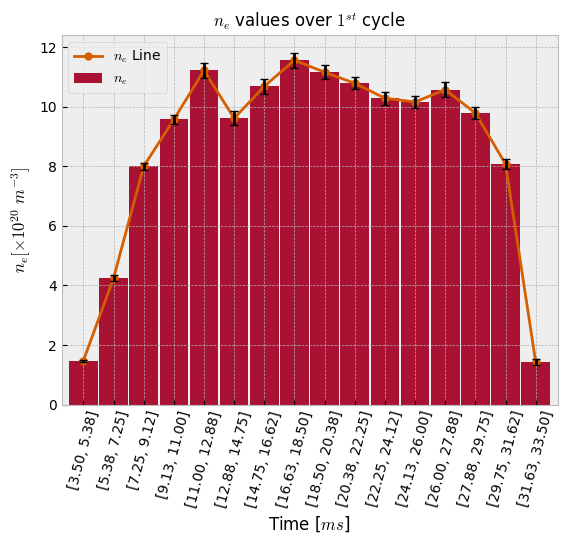

In [45]:
df = pd.DataFrame(dict(data=np.array(n_e_Time)/1e20))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C4', ms=10, label = r'$n_{e}$ Line')
df['data'].plot(kind='bar', color='C1', alpha = 0.95, width = 0.95, label = r'$n_{e}$',
yerr=[val/1e20 for val in n_e_Time_Epsilon], capsize=3)
plt.title(r'$n_{e}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$n_{e} [\times 10^{20}$ $m^{-3}]$')
plt.legend()
plt.savefig('2_n_e(t).svg', format = 'svg')
plt.show()

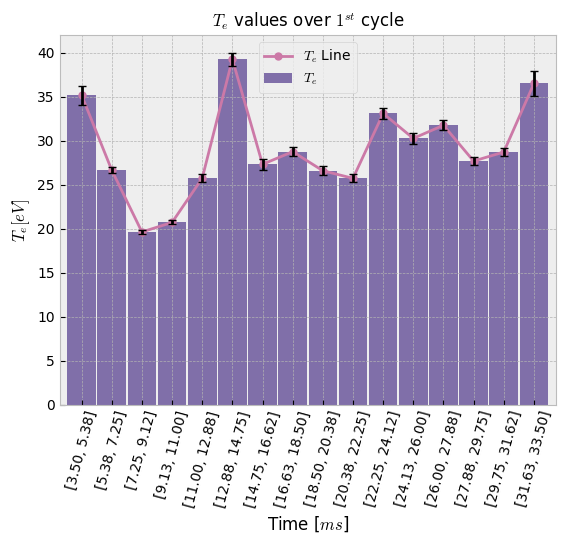

In [46]:
df = pd.DataFrame(dict(data=np.array(T_e_Time)*k/e))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C5', ms=10, label = r'$T_{e}$ Line')
df['data'].plot(kind='bar', color='C2', alpha = 0.95, width = 0.95, label = r'$T_{e}$',
yerr=np.array(T_e_Time_Epsilon)*k/e, capsize=3)
plt.title(r'$T_{e}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$T_{e} [eV]$')
plt.legend()
plt.savefig('2_T_e(t).svg', format = 'svg')
plt.show()

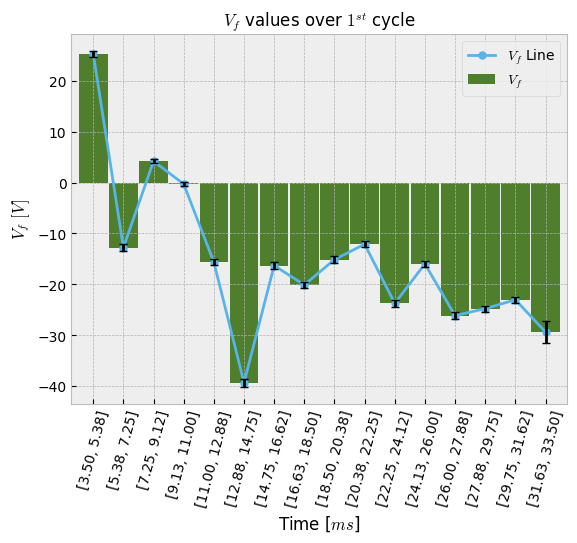

In [47]:
df = pd.DataFrame(dict(data=np.array(V_f_Time)))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C6', ms=10, label = r'$V_{f}$ Line')
df['data'].plot(kind='bar', color='C3', alpha = 0.95, width = 0.95, label = r'$V_{f}$',
yerr=np.array(V_f_Time_Epsilon), capsize=3)
plt.title(r'$V_{f}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$V_{f}$ $[V]$')
plt.legend()
plt.savefig('2_V_f(t).svg', format = 'svg')
plt.show()

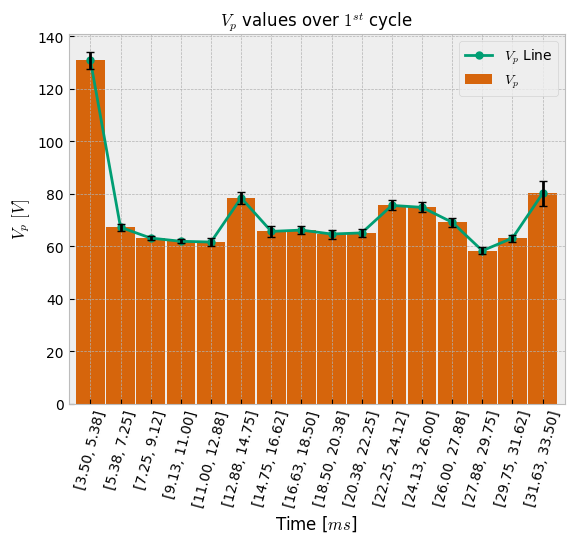

In [48]:
df = pd.DataFrame(dict(data=np.array([val.n for val in V_p_Time])))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C7', ms=10, label = r'$V_{p}$ Line')
df['data'].plot(kind='bar', color='C4', alpha = 0.95, width = 0.95, label = r'$V_{p}$',
yerr=[val.s for val in V_p_Time], capsize=3)
plt.title(r'$V_{p}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$V_{p}$ $[V]$')
plt.legend()
plt.savefig('2_V_p(t).svg', format = 'svg')
plt.show()

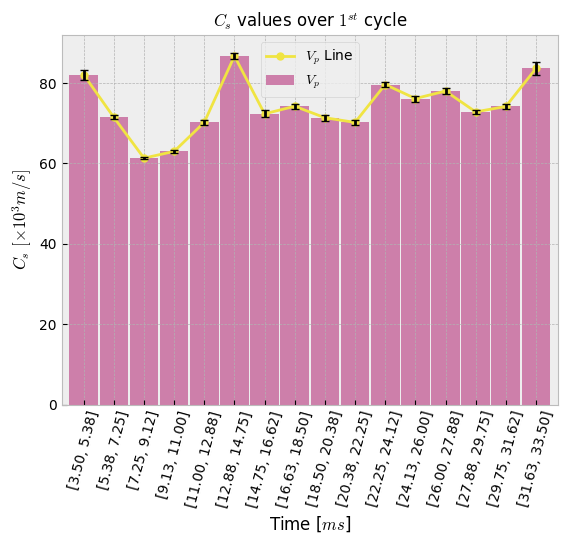

In [49]:
df = pd.DataFrame(dict(data=np.array([val.n/1e3 for val in C_s_Time])))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C18', ms=10, label = r'$V_{p}$ Line')
df['data'].plot(kind='bar', color='C5', alpha = 0.95, width = 0.95, label = r'$V_{p}$',
yerr=[val.s/1e3 for val in C_s_Time], capsize=3)
plt.title(r'$C_{s}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$C_{s}$ $[\times 10^{3} m/s]$')
plt.legend()
plt.savefig('2_C_s(t).svg', format = 'svg')
plt.show()

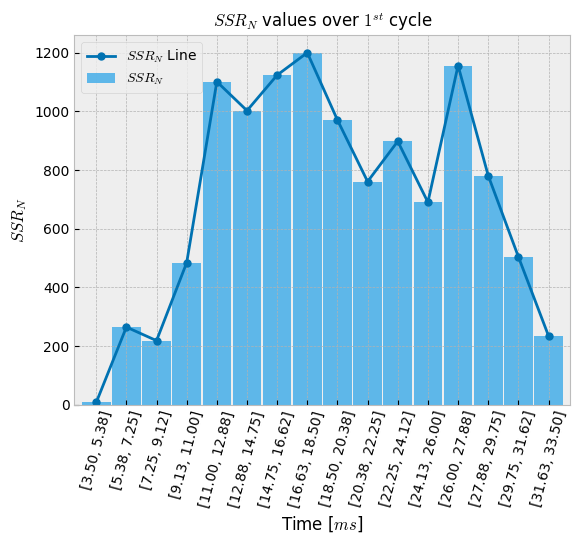

In [51]:
df = pd.DataFrame(dict(data=np.array(SSR_N_Time)))

fig, ax = plt.subplots()

df['data'].plot(kind='line', marker='.', color='C9', ms=10, label = r'$SSR_{N}$ Line')
df['data'].plot(kind='bar', color='C6', alpha = 0.95, width = 0.95, label = r'$SSR_{N}$', capsize=3)
plt.title(r'$SSR_{N}$ values over $1^{st}$ cycle', fontsize=12)
plt.xlabel(r'Time [$ms$]')
plt.xticks(np.arange(split_j), labels=tuple(labels), rotation=75)
plt.ylabel(r'$SSR_{N}$')
plt.legend()
plt.savefig('2_SSR_N(t).svg', format = 'svg')
plt.show()